In [1]:
import os
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

plt_style = 'https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle'

In [2]:
from curlyBrace import curlyBrace
from matplotlib.patches import Polygon

### Settings

$y_i = \pm 1$,
$\quad \boldsymbol{x}_{i} \,|\, y_i \sim \mathcal{N}(y_i \boldsymbol\mu, \mathbf{I}_d)$,
$\quad \boldsymbol\mu = \mu \mathbf{e}_1
= (\mu, 0, \cdots, 0)^\top$, $ \quad \mu > 0$.

Consider
$\pi = C_\pi d^{-a}, \mu^2 = C_\mu d^b,n = C_n d^{c+1}$ for $a,b,c > 0$.

Suppose
$a < c + 1$, then $n \pi \rightarrow \infty$ (non-vanishing for minority sample size).

In [3]:
class InfeasibleError(Exception):
   """ Infeasible Problem """
   pass

def sim_data(n, d, pi, mu, sig1=1, sig0=1):
    """ Generate Gaussian Mixture Data """
    n1 = int(np.ceil(n * pi))
    n0 = n - n1
    mu1 = np.append(mu, np.zeros(d-1))
    mu0 = -mu1
    Sig1 = sig1*np.identity(d)
    Sig0 = sig0*np.identity(d)
    X1 = np.random.multivariate_normal(mean=mu1, cov=Sig1, size=n1)
    X0 = np.random.multivariate_normal(mean=mu0, cov=Sig0, size=n0)
    X = np.vstack([X1, X0])
    y = np.repeat([1, 0], [n1, n0])
    # print(dict(Counter(y)))
    return [X, y]

def SVM(X, y, C=1, shrinking=True, tol=1e-8, class_weight=None, standard=True):
    clf = SVC(C=C, kernel='linear', shrinking=shrinking, tol=tol, class_weight=class_weight)
    clf.fit(X, y)
    beta = clf.coef_[0]
    beta0 = clf.intercept_[0]
    kappa = 1
    if standard:
        beta_norm = np.linalg.norm(beta)
        beta, beta0, kappa = beta/beta_norm, beta0/beta_norm, kappa/beta_norm
    return [clf, beta, beta0, kappa]

def get_accuracy_01(y_pred, y):
    ind1 = np.where(y == 1)
    ind0 = np.where(y == 0)
    res = y - y_pred
    # calculate overall, majority, minority, accuracy
    acc = np.mean(res == 0)
    acc0 = np.mean(res[ind0] == 0)
    acc1 = np.mean(res[ind1] == 0)
    return [acc, acc0, acc1]

def get_model(pi, n, d, mu, terminate=False):
    X_train, y_train = sim_data(n=n, d=d, pi=pi, mu=mu)
    md, beta, beta0, kappa = SVM(X_train, y_train, C=1)
    # Check linear separability
    if np.mean(md.predict(X_train) == y_train) < 1:
        if terminate:
            raise InfeasibleError(f'Training data is not separable.')
        else:
            print(f'Training data is not separable.')
    # two support vectors in each class
    idx_SV = np.array([np.where(y_train[md.support_] == 1)[0][0],
                       np.where(y_train[md.support_] == 0)[0][0]])
    SV2 = md.support_vectors_[idx_SV, :]
    return [[X_train, y_train], md, beta, beta0, kappa, SV2]

### Experiment Design

Recall $a - c < 1$.

- **Case 1.** (high signal)  $\quad a - c < b$ $\quad \Rightarrow \quad $ $\mu^2 \cdot (\pi\delta) \rightarrow \infty$.
- **Case 2.** (moderate signal) $\quad b < a - c < 2b$ $\quad \Rightarrow \quad $ $\mu^2 \cdot (\pi\delta) \rightarrow 0$,
$\quad \mu^4 \cdot (\pi\delta) \rightarrow \infty$.
- **Case 3.** (low signal) $\quad a - c > 2b$ $\quad \Rightarrow \quad $ $\mu^4 \cdot (\pi\delta) \rightarrow 0$.

### Heatmap A
#### ($a-c$ v.s. $b$, facet $\tau$)

Fix $c$ and take $\tau = 1, d^{(a-b-c)_+}, d^{b/2}, d^{(a-c)/2}$, change $a - c$ and $b$.

- `heatmap`: generate (and save) data for heatmap.

In [4]:
def heatmap(c, a_c_arr, b_arr, d=1000, C_pi=1, C_mu=1, C_n=1,
            REP=10, n_test=100000, seed=2023, terminate=True):
    if np.max(a_c_arr) > 1:
        raise ValueError('a - c < 1 is required.')
    a_arr = a_c_arr + c

    a_len = a_arr.shape[0]
    b_len = b_arr.shape[0]
    acc_df = np.zeros((a_len, b_len, 4, 3))
    rho_df = np.zeros((a_len, b_len))
    beta0_df = np.zeros((a_len, b_len, 4))

    n = int(C_n * d ** (c+1))
    print(f'pi_max = C_pi * d^(-a_min) = {C_pi * d ** (-np.min(a_arr))}\n' +
          f'n1_min = C_n * C_pi * d^(1 - [a-c]_max) = {int(np.ceil(C_n * C_pi * d ** (1 - np.max(a_c_arr))))}')
    np.random.seed(seed)
    for a_idx, a in enumerate(a_arr):
        pi = C_pi / (d ** a)
        print(f'\nn = {n}, n1 = {int(n*pi)}')
        for b_idx, b in enumerate(b_arr):
            mu = C_mu * d ** (b/2)
            if b_idx < 2 or  b_idx == b_len - 1:
                print(f'a-c = {a-c:0.2f}, b = {b:0.2f}     pi = {pi:0.2e}, mu = {mu:0.2e}, ')
                if b_idx == 1:
                    print('... ... ...')
            X_test, y_test = sim_data(n=n_test, d=d, pi=0.5, mu=mu)
            for rep_idx in range(REP):
                data_train, md, beta, beta0, kappa, SV2 = get_model(pi=pi, n=n, d=d, mu=mu, terminate=terminate)
                rho_df[a_idx, b_idx] += beta[0]
                # w/ margin aware adjustment
                tmp_inner = SV2 @ beta
                tau_arr = d ** np.array([0, np.max([a - b - c, 0]), b/2, (a - c)/2])
                for tau_idx, tau in enumerate(tau_arr):
                    beta0_tau = -np.inner(np.array([1, tau]), tmp_inner)/(1 + tau)
                    yhat_test = (np.sign(X_test @ beta + beta0_tau) + 1)/2
                    acc_df[a_idx, b_idx, tau_idx, :] += get_accuracy_01(yhat_test, y_test)
                    beta0_df[a_idx, b_idx, tau_idx] += beta0_tau
    acc_df, rho_df, beta0_df = acc_df/REP, rho_df/REP, beta0_df/REP
    return acc_df, rho_df, beta0_df

Run/save/load summary data.

In [5]:
# Uncomment this block to re-generate simulated data

# t0 = time.time()
# df = heatmap(c=0.1, a_c_arr=np.round(np.linspace(0, 1, 21), 2), b_arr=np.round(np.linspace(0, 1.2, 25), 2),
#              d=2500, C_pi=1, C_mu=0.5, C_n=1, REP=1)
# t1 = time.time()
# print(f'Total running time: {str(datetime.timedelta(seconds=t1-t0))}')
#
# acc_df, rho_df, beta0_df = df

# np.save('tmp_data/acc_df(1500).npy', acc_df)
# np.save('tmp_data/rho_df(1500).npy', rho_df)
# np.save('tmp_data/beta0_df(1500).npy', beta0_df)

In [6]:
acc_df = np.load('tmp_data/A_acc_df(1500).npy')
rho_df = np.load('tmp_data/A_rho_df(1500).npy')
beta0_df = np.load('tmp_data/A_beta0_df(1500).npy')

- `heatmap_plot`: get heatmap figure.

In [7]:
def heatmap_plot(acc_df, extents, path, dpi=200):
    figsize = (5.3, 4)
    file_cat = ['tau=1, ', 'tau_pow=a-b-c, ', 'tau_pow=0.5b, ', 'tau_pow=0.5(a-c), ']
    os.makedirs(path, exist_ok=True)
    for i in range(4):
        header = ''
        # Plot Majority Accuracy
        fig, ax = plt.subplots(dpi=dpi, figsize=figsize, constrained_layout=True)
        im = ax.imshow(acc_df[:, :, i, 1], cmap='hot', origin='lower', extent=extents, vmin=0, vmax=1)
        col_bar = ax.figure.colorbar(im, ax = ax)
        col_bar.ax.set_ylabel('', rotation = -90, va = "bottom")
        ax.set_title(r'Majority Accuracy' + header)
        ax.set_xlabel(r'$b$')
        ax.set_ylabel(r'$a-c$')
        plt.savefig(path + file_cat[i] + 'acc_majority.pdf')
        plt.close()

        # Plot Minority Accuracy
        fig, ax = plt.subplots(dpi=dpi, figsize=figsize, constrained_layout=True)
        im = ax.imshow(acc_df[:, :, i, 2], cmap='hot', origin='lower', extent=extents, vmin=0, vmax=1)
        col_bar = ax.figure.colorbar(im, ax = ax)
        col_bar.ax.set_ylabel('', rotation = -90, va = "bottom")
        ax.plot([0, 1], [0, 1], 'r--')
        ax.plot([0, 0.5], [0, 1], 'y--')
        ax.set_title(r'Minority Accuracy' + header)
        ax.set_xlabel(r'$b$')
        ax.set_ylabel(r'$a-c$')
        yMAX = extents[3]
        txt_adj = yMAX/25
        ax.text(3*yMAX/8, 3*yMAX/4 + txt_adj/np.cos(np.arctan(2)), r'$a - c = 2b$',
                    fontsize=10, color='yellow', ha='center', va='center', rotation=np.degrees(np.arctan(2)))
        ax.text(3*yMAX/4, 3*yMAX/4 + txt_adj/np.cos(np.arctan(1)), r'$a - c = b$',
                    fontsize=10, color='red', ha='center', va='center', rotation=45)
        Len = 2*yMAX/3
        ax.text(Len*np.sin(np.arctan(1/2)/2), Len*np.cos(np.arctan(1/2)/2), '(i)',
                    fontsize=10, weight='bold', color='gray', ha='center', va='center')
        ax.text(Len*np.cos((np.arctan(1) + np.arctan(2))/2), Len*np.sin((np.arctan(1) + np.arctan(2))/2), '(ii)',
                    fontsize=10, weight='bold', color='gray', ha='center', va='center')
        ax.text(Len*np.cos(np.arctan(1)/2), Len*np.sin(np.arctan(1)/2), '(iii)',
                    fontsize=10, weight='bold', color='gray', ha='center', va='center')
        plt.savefig(path + file_cat[i] + 'acc_minority.pdf')
        plt.close()
    return None

In [8]:
heatmap_plot(acc_df, extents = (0, 1.2, 0, 1), path = 'Heatmap a-c_vs_b/')

### Heatmap B
#### ($\tau$ v.s. $a-c$)

Fix $c$ and $b$, set $\tau = d^r$, change $a - c$ and $r$.

In [9]:
def heatmap_fix_b(b, c, a_c_arr, r_arr, d=1000, C_pi=1, C_mu=1, C_n=1,
                  REP=10, n_test=100000, seed=2023, terminate=True):
    if np.max(a_c_arr) > 1:
        raise ValueError('a - c < 1 is required.')
    a_arr = a_c_arr + c

    a_len = a_arr.shape[0]
    r_len = r_arr.shape[0]
    acc_df = np.zeros((a_len, r_len, 3))
    beta0_df = np.zeros((a_len, r_len))

    n = int(C_n * d ** (c+1))
    mu = C_mu * d ** (b/2)
    tau_arr = d ** r_arr
    print(f'pi_max = C_pi * d^(-a_min) = {C_pi * d ** (-np.min(a_arr))}\n' +
          f'n1_min = C_n * C_pi * d^(1 - [a-c]_max) = {int(np.ceil(C_n * C_pi * d ** (1 - np.max(a_c_arr))))}\n')
    np.random.seed(seed)
    for a_idx, a in enumerate(a_arr):
        pi = C_pi / (d ** a)
        print(f'n = {n}, n1 = {int(n*pi)}')
        X_test, y_test = sim_data(n=n_test, d=d, pi=0.5, mu=mu)
        for rep_idx in range(REP):
            data_train, md, beta, beta0, kappa, SV2 = get_model(pi=pi, n=n, d=d, mu=mu, terminate=terminate)
            # w/ margin aware adjustment
            tmp_inner = SV2 @ beta
            for tau_idx, tau in enumerate(tau_arr):
                beta0_tau = -np.inner(np.array([1, tau]), tmp_inner)/(1 + tau)
                yhat_test = (np.sign(X_test @ beta + beta0_tau) + 1)/2
                acc_df[a_idx, tau_idx, :] += get_accuracy_01(yhat_test, y_test)
                beta0_df[a_idx, tau_idx] += beta0_tau
        acc_df, beta0_df = acc_df/REP, beta0_df/REP
    return acc_df, beta0_df

Run/save/load summary data.

In [10]:
# Uncomment this block to re-generate simulated data

# b = 0.4
# t0 = time.time()
# df = heatmap_fix_b(b=b, c=0.1, a_c_arr=np.round(np.linspace(0, 1, 51), 2),
#                    r_arr=np.round(np.linspace(0, 1, 51), 2),
#                    d=2000, C_pi=1, C_mu=0.75, C_n=1, REP=1)
# t1 = time.time()
# print(f'Total running time: {str(datetime.timedelta(seconds=t1-t0))}')

# acc_df, beta0_df = df
# np.save(f'tmp_data/B_(b={b})_acc.npy', acc_df)
# np.save(f'tmp_data/B_(b={b})_beta0.npy', beta0_df)

In [11]:
def heatmap_fix_b_plot(b, extent, header='', file_cat='Cmu=0.75, ', d=2000, c=0.1, Cmu=0.75,
                       dpi=200, save=False):
    err_df = 1 - np.load(f'tmp_data/B_(b={b})_acc.npy')
    path = f'Heatmap tau vs a-c/d={d}, b={b}, c={c}, Cmu={Cmu}/'
    os.makedirs(path, exist_ok=True)

    fig_names = ['Balanced', 'Majority', 'Minority']
    for fig_idx, fig_name in enumerate(fig_names):
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')
        plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
        fig, ax = plt.subplots(dpi=dpi, figsize=(4.6, 4), constrained_layout=True)
        im = ax.imshow(err_df[:, :, fig_idx].T, cmap=plt.cm.hot.reversed(),
                       origin='lower', extent=extent, vmin=0, vmax=1)
        col_bar = ax.figure.colorbar(im, ax = ax)
        col_bar.ax.set_ylabel('', rotation = -90, va = "bottom")
        ax.set_xlim([0, 1])
        yMAX = extent[3]
        if fig_name == 'Balanced':
            None
        elif fig_name == 'Majority':
            ax.plot([b, 2*b], [b/2, b], 'r--')
            ax.plot([0, b], [b/2, b/2], 'r--')
        else:
            ax.plot([b, 2*b, 2*b], [0, b, 1], 'r--')

        # Annotate three phases
        ax.axvline(x=b, color='r', linestyle=':')
        ax.axvline(x=2*b, color='r', linestyle=':')
        curlyBrace(fig, ax, [b, yMAX], [0, yMAX], k_r=0.05, bool_auto=True, int_line_num=3,
                   str_text='(i)\nHigh signal', color='k', lw=1, fontdict={'color': 'k', 'size': 9})
        curlyBrace(fig, ax, [2*b, yMAX], [b, yMAX], k_r=0.05, bool_auto=True, int_line_num=3,
                   str_text='(ii)\nModerate signal', color='k', lw=1, fontdict={'color': 'k', 'size': 9})
        curlyBrace(fig, ax, [1, yMAX], [2*b, yMAX], k_r=0.035, bool_auto=True, int_line_num=3,
                   str_text='(iii)\nLow signal', color='white' if fig_name == 'Minority' else 'k', lw=1,
                   fontdict={'color': 'white' if fig_name == 'Minority' else 'k', 'size': 9})
        txt_adj = yMAX/25
        txt_col = '#8B0000'
        if fig_name == 'Balanced':
            vertices = [[b, 0], [2*b, b], [b, b/2], [0, b/2]]
            polygon = Polygon(vertices, closed=False, facecolor='none', edgecolor='black',
                              linewidth=2, linestyle='dashed')
            ax.add_patch(polygon)
            ax.text(2*b/3, b/4, 'acceptable region\n' + r'for $\tau = d^r$',
                    fontsize=10, color='black', ha='center', va='center')
        if fig_name == 'Majority':
            ax.text(b/2, b/2 + txt_adj, r'$\tau = d^{b/2}$', fontsize=10, color=txt_col, ha='center', va='center')
            ax.text(3*b/2, 3*b/4 + txt_adj/np.cos(np.arctan(1/2)), r'$\tau = d^{(a-c)/2}$',
                    fontsize=10, color=txt_col, ha='center', va='center', rotation=np.degrees(np.arctan(1/2)))
        if fig_name == 'Minority':
            ax.text(b/2, 0 + txt_adj, r'$\tau = 1$', fontsize=10, color=txt_col, ha='center', va='center')
            ax.text(3*b/2, b/2 + txt_adj*np.sqrt(2), r'$\tau = d^{(a-b-c)/2}$',
                    fontsize=10, color=txt_col, ha='center', va='center', rotation=45)

        ax.set_xlabel(r'$a-c$')
        ax.set_ylabel(r'$r = \log_d(\tau)$')
        ax.set_title(rf'\textbf{{{fig_name} Error}}' + header)
        if save:
            plt.savefig(path + file_cat + 'err_' + fig_name + '.pdf')
        else:
            plt.show()
    return None

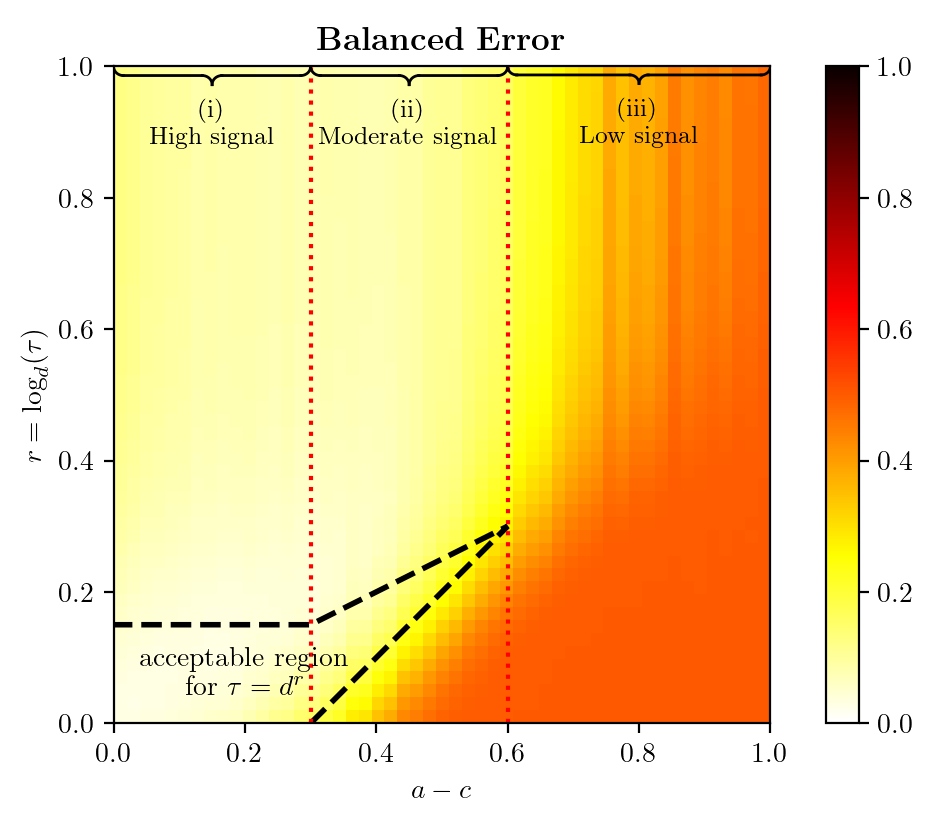

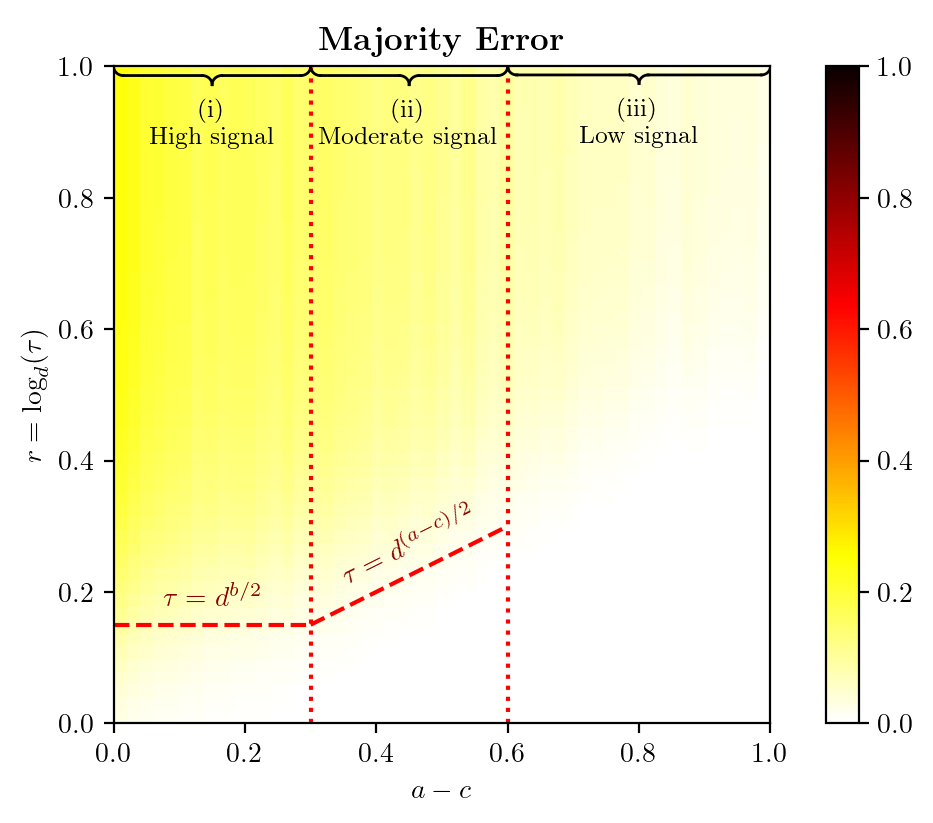

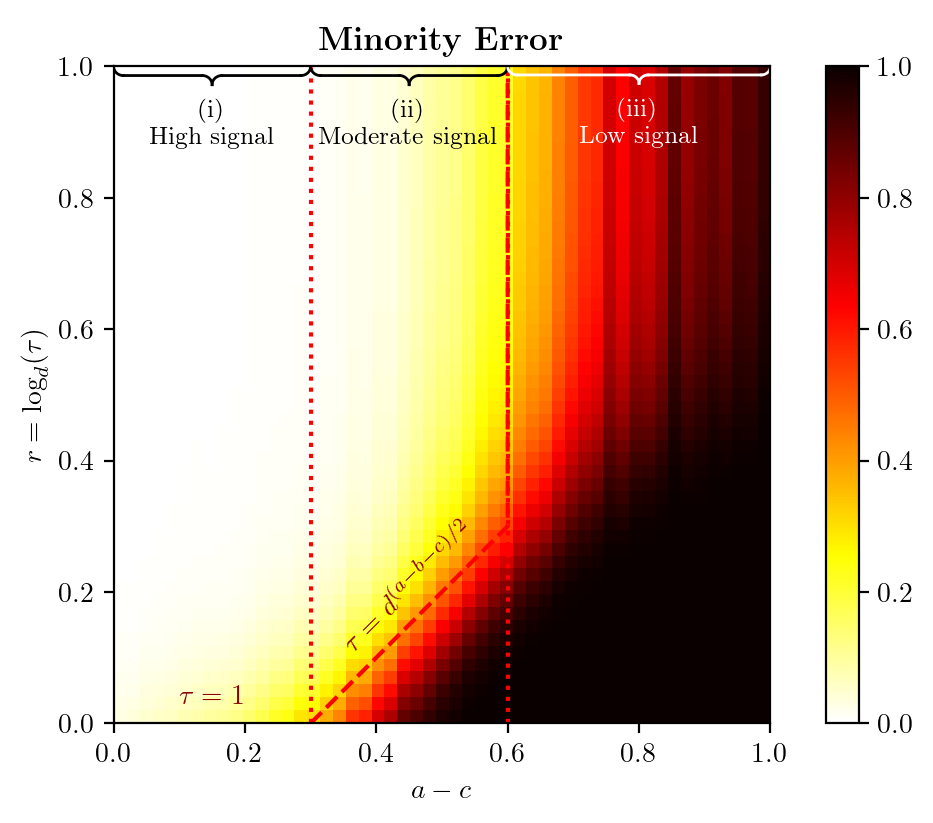

In [12]:
heatmap_fix_b_plot(b=0.3, extent=(0, 1, 0, 1), save=True)